In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import pandas as pd
import random
import numpy as np
import os 
import math
import torch

import copy
import time
import math

import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

from torch.utils.tensorboard import SummaryWriter
torch.set_default_dtype(torch.float)

import mads_dl
torch.set_default_dtype(torch.float)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import torch.nn as nn
import mads_dl




# Step 1: Loading the data

In [2]:
# load the data
def load_data():
    path_list = []
    cwd = Path(os.getcwd())
    print(f'Working Dir: {cwd}')
    data_path = os.path.join(cwd.parent, 'Data')

    print(f'Path: {data_path}')
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('FA_20231113_2H_yeast_Pyruvate-d3_1.csv'):
                file_path = os.path.join(root, file)
                path_list.append(file_path)
    return path_list
# FA_20231113_2H_yeast_Pyruvate-d3_1.csv

path_list = load_data()
print(path_list)

Working Dir: d:\Dokumente\MoinCC-AI4metabolomics\NMRQNet
Path: d:\Dokumente\MoinCC-AI4metabolomics\Data
['d:\\Dokumente\\MoinCC-AI4metabolomics\\Data\\FA_20231113_2H_yeast_Pyruvate-d3_1.csv']


In [3]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(1503, 131)


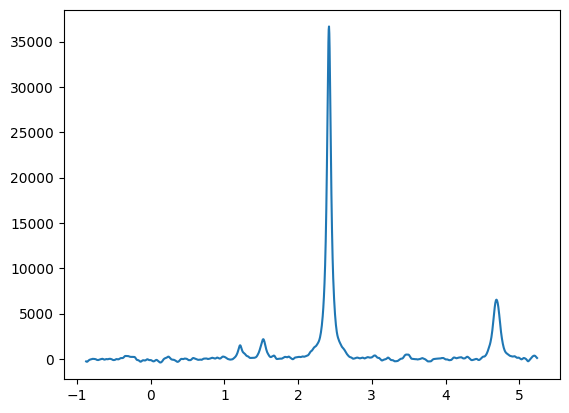

In [4]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    df['sum'] = df.iloc[:,1:].sum(axis=1)

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)


plt.show()

In [5]:
df['sum']

0       -852.953510
1      -1168.218890
2      -1524.973790
3      -1905.063789
4      -2313.660113
           ...     
1498    6968.597040
1499    6811.509176
1500    6645.824694
1501    6291.822860
1502    5931.063100
Name: sum, Length: 1503, dtype: float64

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

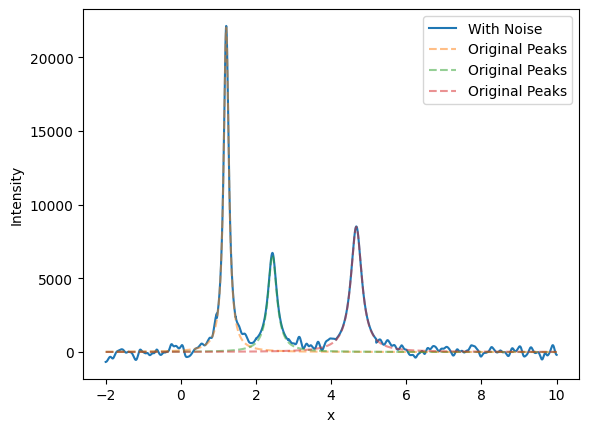

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=5000):
    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 10, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    #np.random.seed(0)
    
    lorenz_curves = []
    for peak_pos in peak_list:
        x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        #print(x0) 
        gamma = np.random.uniform(0.05, 0.2)  # Random width (gamma)
        height = np.random.uniform(0, 40000)  # Random height
        peak = lorentzian(x, x0, gamma, height)
        y += peak

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak > (0.1 * height)  # Masking regions where peak height is significant

        # Append all Original Lorenz Cuves to the list
        lorenz_curves.append(peak)

    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(100, spectrum_length)
    noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level / 100
    noise = gaussian_filter1d(noise, sigma=sigma)
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(lorenz_curves)


# ----

#peak_list = [2.323, 4.7, 1.201]
pyruvate_list = [1.2261, 2.468, 4.7]
x, y_noisy, lorenz_curves = generate_random_spectrum(pyruvate_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for lorenz in lorenz_curves:
    plt.plot(x, lorenz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

          x           y
0 -2.000000 -158.254504
1 -1.995927 -155.851455
2 -1.991855 -150.572277
3 -1.987782 -141.946865
4 -1.983710 -130.357739


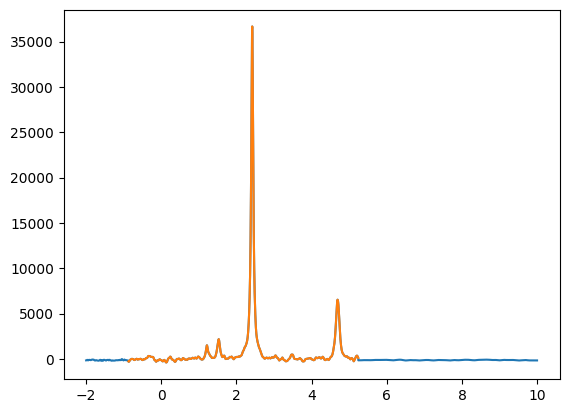

(2949, 2)


In [7]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=5000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 20
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = y_sample.min(), abs(y_sample.min())
    x_min, x_max = x_sample.min(), abs(x_sample.min())

    if x_min > -2:

        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))
        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 10:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 10, step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(y_min, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, 0:2]
#print(df_fill.head())
df_filled = fill_df(df_fill)
print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1])
plt.show()
print(df_filled.shape)


# Step 3: Bring data to same shape

(5000, 2)


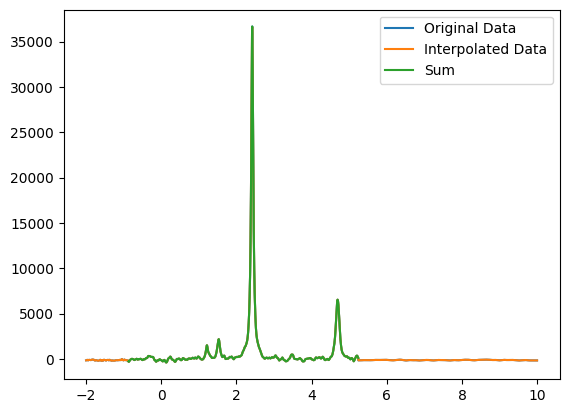

In [8]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=5000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1])
plt.plot(df.iloc[:, 0], df.iloc[:, 1])
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [9]:
df_interpolated.shape

(5000, 2)

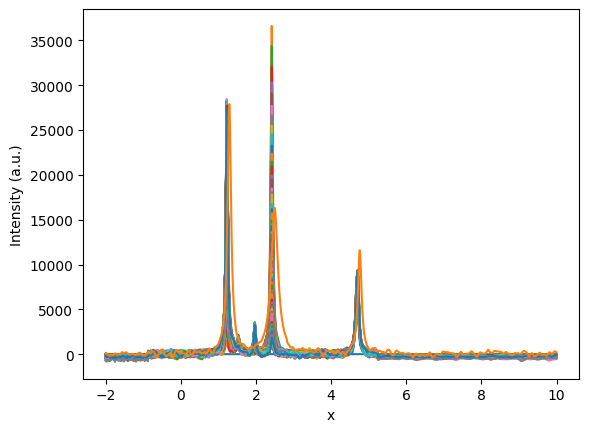

In [10]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=5000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# X_train & y_train
pyruvate_list = [2.468, 4.7, 1.2261]
x_synth, y_synth, lorenz_curves = generate_random_spectrum(pyruvate_list, spectrum_length=5000)


plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [11]:

num_samples = 100

x_data = []
y_data = []
lorenzes = []
for i in range(num_samples):
    # X_train & y_train
    pyruvate_list = [2.468, 4.7, 1.2261]
    x, y_noisy, lorenz_curves = generate_random_spectrum(pyruvate_list, spectrum_length=5000)
    x_data.append(x)
    y_data.append(y_noisy)
    lorenzes.append(lorenz_curves)


# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
target = torch.tensor(lorenzes) # Target: Original Lorentzian Curves, which is output of the model

# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"lorenzes shape: {target.shape}")
print('\n')

x_data shape: torch.Size([100, 5000])
data shape: torch.Size([100, 5000])
lorenzes shape: torch.Size([100, 3, 5000])




C:\Users\Gener\AppData\Local\Temp\ipykernel_4804\2326777056.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  x_data = torch.tensor(x_data)


In [12]:
def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')
    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data.reshape(data.shape[0], -1))
    target_scaled = target_scaler.fit_transform(target.reshape(target.shape[0], -1))
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([100, 5000])
Before Scaling: torch.Size([100, 3, 5000])
After Scaling: (100, 5000)
After Scaling: (100, 15000)


In [43]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train.reshape(data_train.shape[0], -1))
data_test_sc = data_scaler.transform(data_test.reshape(data_test.shape[0], -1))

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train.reshape(target_train.shape[0], -1))
target_test_sc = target_scaler.transform(target_test.reshape(target_test.shape[0], -1))


# Konvertieren in Tensoren
data_train_tensor = torch.Tensor(data_train_sc)
data_test_tensor = torch.Tensor(data_test_sc)
target_train_tensor = torch.Tensor(target_train_sc)
target_test_tensor = torch.Tensor(target_test_sc)


# Reshape the tensors for the model
target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], 3, -1)
target_test_tensor = target_test_tensor.reshape(target_test_tensor.shape[0], 3, -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([60, 5000])
Data Test Shape: torch.Size([40, 5000])
Target Train Shape: torch.Size([60, 3, 5000])
Target Test Shape: torch.Size([40, 3, 5000])


## Implementing Multilayer Network

In [46]:
print(f"Verwende Gerät: {device}")

criterion = torch.nn.MSELoss().to(device)
learning_rate=0.01
epochs=1000

# Daten auf die GPU verschieben
data_train_tensor = data_train_tensor.to(device)
data_test_tensor = data_test_tensor.to(device)
target_train_tensor = target_train_tensor.to(device)
target_test_tensor = target_test_tensor.to(device)



Verwende Gerät: cuda


In [47]:
# MultiLayerPerceptron-Modell
import torch.nn as nn
import torch.optim as optim

class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(MultiLayerPerceptron, self).__init__()
                
        self.hidden_1 = nn.Linear(input_size, hidden_size)
        self.hidden_2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.hidden_3 = nn.Linear(int(hidden_size/2), hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation=nn.ReLU()
 
    def forward(self, x):
        if len(x.shape) >2:
            x = x.reshape(x.shape[0], -1)

        out1 = self.activation(self.hidden_1(x))
        out2 = self.activation(self.hidden_2(out1))
        out3 = self.activation(self.hidden_3(out2))
        
        return self.output(out3)

In [48]:

# Modell initialisieren
input_size = data_train_tensor.shape[1]
hidden_size = 512
output_size = data_train_tensor.shape[1]  # Da wir 3 Targets mit 10000 Features haben
model = MultiLayerPerceptron(input_size, hidden_size, output_size).to(device)

# Loss und Optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [74]:
# Training function
def train_model(model, X_train, y_train, criterion, optimizer, epochs):
    model.train()

    for epoch in range(epochs):
        y_train_pred = model(X_train)
        optimizer.zero_grad()
        print(y_train_pred.shape)
        print(y_train.shape)
        train_loss = criterion(y_train_pred, y_train)
        
        train_loss.backward()

        optimizer.step()

        if (epoch % 100==99):
            print("Epoch: %d, loss: %1.5f" % (epoch, train_loss.item()))

In [75]:
train_model(model, data_train_tensor, target_train_tensor, criterion, optimizer, epochs)

torch.Size([60, 5000])
torch.Size([60, 3, 5000])


RuntimeError: The size of tensor a (60) must match the size of tensor b (3) at non-singleton dimension 1

In [8]:
# Use a dataframe to collect general evaluation results
results = pd.DataFrame()

# We will reuse this function. Hence we copy it to mads_dl.py
def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
    '''
    Create a table with evaluation results
    of a regression experiment
    '''
    for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
        mse=mean_squared_error(actual, predicted)
        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm, 
            "dataset": dataset,
            "MSE": mse,
            "RMSE": math.sqrt(mse),
            "MAE": mean_absolute_error(actual, predicted),
            "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
            "params": num_params
        }])], ignore_index=True)   
    return results


In [9]:
print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'X_test_tensor shape: {X_train_tensor.shape}')
print(f'y_train_tensor shape: {y_train_tensor.shape}')
print(f'y_test_tensor shape: {y_test_tensor.shape}')
print('\n')

# Vorhersagen und Rückskalierung
y_train_pred = predict(model, X_train_tensor).view(-1,2, 10000).cpu().detach().numpy()
y_test_pred = predict(model, X_train_tensor).view(-1,2, 10000).cpu().detach().numpy()

print(f'X_train_tensor shape: {X_train_tensor.shape}')
print(f'X_test_tensor shape: {X_train_tensor.shape}')
# Rückskalieren der Vorhersagen
y_train_pred_reshaped = y_train_pred.reshape(-1, 10000)
y_test_pred_reshaped = y_test_pred.reshape(-1, 10000)
print(f'y_train_pred_reshaped shape: {y_train_pred_reshaped.shape}')
y_train_pred_rescaled = y_scaler.inverse_transform(y_train_pred_reshaped)
y_test_pred_rescaled = y_scaler.inverse_transform(y_test_pred_reshaped)

X_train_tensor shape: torch.Size([1200, 10000])
X_test_tensor shape: torch.Size([1200, 10000])
y_train_tensor shape: torch.Size([1200, 2, 10000])
y_test_tensor shape: torch.Size([800, 2, 10000])


X_train_tensor shape: torch.Size([1200, 10000])
X_test_tensor shape: torch.Size([1200, 10000])
y_train_pred_reshaped shape: (2400, 10000)


In [10]:
data.shape, target.shape

(torch.Size([2000, 10000]), torch.Size([2000, 2, 10000]))

y_train_tensor shape: torch.Size([1200, 2, 10000])
(800, 3, 10000)


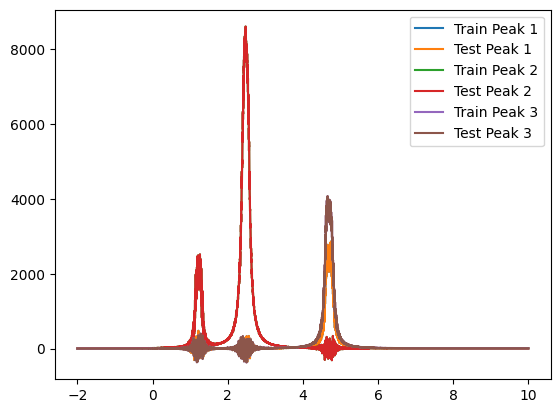

In [16]:
print(f'y_train_tensor shape: {y_train_tensor.shape}')
y_train_pred_rescaled = y_train_pred_rescaled.reshape(-1, 3, 10000)
y_test_pred_rescaled = y_test_pred_rescaled.reshape(-1, 3, 10000)

#y_test_pred_rescaled = y_test_pred_rescaled.reshape(-1, 3, 10000)
print(y_train_pred_rescaled.shape)

x_original = x_data[1]
for i in range(3):
    y_plot = y_train_pred_rescaled[0,i,:]
    plt.plot(x_original, y_plot, label=f'Train Peak {i+1}')
    y_plot = y_test_pred_rescaled[0,i,:]
    plt.plot(x_original, y_plot, label=f'Test Peak {i+1}')

#x_new, interpolated_data = interpolate_to_shape(x_original, y_original)
plt.legend()
plt.show()




# Test on Data

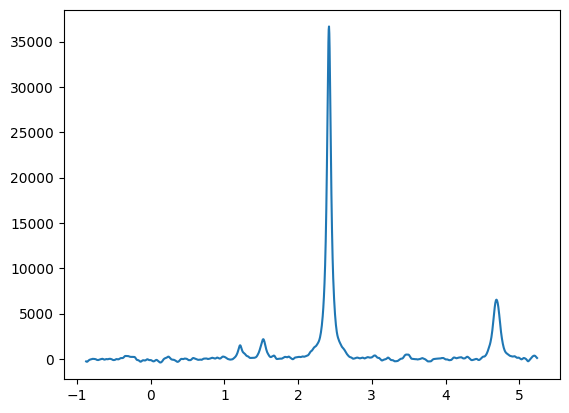

In [12]:

df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 1]
plt.plot(x,y)
plt.show()

In [13]:
df = pd.read_csv(path_list[0]) 
df['sum'] = df.iloc[:,1:].sum(axis=1)
x = df.iloc[:,0]
y = df.iloc[:, 1]

# apllying interpolation
x, y = interpolate_to_shape(x, y)

x = torch.tensor(x).to('cpu')
y = torch.tensor(y).to('cpu')
data = torch.cat((x, y), dim=0)

# umformen der daten für das scalieren
data = data.reshape(-1, 10000)
print(data.shape)
# Skalieren der Daten
data = x_scaler.transform(data)

# Zurückformen der Daten in die ursprüngliche Form
data = data.reshape(data.shape)

# Konvertieren in Tensoren
data = torch.Tensor(data).to(device)
data = data.reshape(-1, 10000)

pred = predict(model, data).view(-1,2, 10000).cpu().detach().numpy()

pred = pred.reshape(-1, 10000)

print(f'y_train_pred_reshaped shape: {y_train_pred_reshaped.shape}')

pred = y_scaler.inverse_transform(pred)


x_pred = pred[0,:]
y_pred = pred[1:,:]
print(y_pred.shape)





torch.Size([2, 10000])
y_train_pred_reshaped shape: (2400, 10000)
(3, 10000)


y_pred shape after reshaping: (3, 10000)


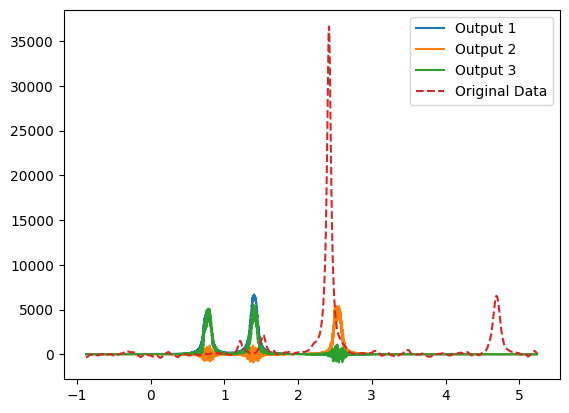

In [18]:

# Überprüfen der neuen Form
print(f'y_pred shape after reshaping: {y_pred.shape}')

# Plotten der Daten
for i in range(3):
    y_pred_sample = y_pred[i, :]  # Zugriff auf die erste Probe und die i-te Ausgabe
    plt.plot(x, y_pred_sample, label=f'Output {i+1}')
plt.plot(x, y, label='Original Data', linestyle='--')

plt.legend()
plt.show()